# Train a simple deep CNN on the CIFAR10 small images dataset.

GPU run command with Theano backend (with TensorFlow, the GPU is automatically used):
    THEANO_FLAGS=mode=FAST_RUN,device=gpu,floatx=float32 python cifar10_cnn.py

It gets down to 0.65 test logloss in 25 epochs, and down to 0.55 after 50 epochs.
(it's still underfitting at that point, though).

## Load & Preprocess Data

In [1]:

from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

import os
import pickle
import numpy as np

batch_size = 32
num_classes = 10
epochs = 200
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

# The data, shuffled and split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255


Using TensorFlow backend.


x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [2]:
# Let's take a look at our data
print("Input Dimensions:" + str(x_train[0].shape))
print("Target Dimensions: " + str(y_train[0].shape))
print("Target: " + str(y_train[0]))

Input Dimensions:(32, 32, 3)
Target Dimensions: (10,)
Target: [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]


## Compile Model

In [3]:

model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])


## Real Time Data Augmentation & Training

In [5]:
print('Using real-time data augmentation.')
# This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images

# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

Using real-time data augmentation.


In [4]:
print('Train the model.')
# Fit the model on the batches generated by datagen.flow().
model.fit_generator(datagen.flow(x_train, y_train,
                                 batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test))

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)


Train the model.


NameError: name 'datagen' is not defined

In [6]:
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model = keras.models.load_model(model_path)
print("Model loaded")

Model loaded


## Evaluate model with test data set and share sample prediction results

In [7]:
# Load label names to use in prediction results
label_list_path = 'datasets/cifar-10-batches-py/batches.meta'


keras_dir = os.path.expanduser(os.path.join('~', '.keras'))
datadir_base = os.path.expanduser(keras_dir)
if not os.access(datadir_base, os.W_OK):
    datadir_base = os.path.join('/tmp', '.keras')
label_list_path = os.path.join(datadir_base, label_list_path)

with open(label_list_path, mode='rb') as f:
    labels = pickle.load(f)

# Evaluate model with test data set and share sample prediction results
evaluation = model.evaluate_generator(datagen.flow(x_test, y_test,
                                      batch_size=batch_size),
                                      steps=x_test.shape[0] // batch_size)

print('Model Accuracy = %.2f' % (evaluation[1]))

predict_gen = model.predict_generator(datagen.flow(x_test, y_test,
                                      batch_size=batch_size),
                                      steps=x_test.shape[0] // batch_size)

for predict_index, predicted_y in enumerate(predict_gen):
    actual_label = labels['label_names'][np.argmax(y_test[predict_index])]
    predicted_label = labels['label_names'][np.argmax(predicted_y)]
    print('%d. Actual Label = %s vs. Predicted Label = %s' % (predict_index, actual_label,
                                                          predicted_label))
    if predict_index == num_predictions:
        break

Model Accuracy = 0.68
0. Actual Label = cat vs. Predicted Label = airplane
1. Actual Label = ship vs. Predicted Label = ship
2. Actual Label = ship vs. Predicted Label = cat
3. Actual Label = airplane vs. Predicted Label = frog
4. Actual Label = frog vs. Predicted Label = airplane
5. Actual Label = frog vs. Predicted Label = airplane
6. Actual Label = automobile vs. Predicted Label = horse
7. Actual Label = frog vs. Predicted Label = truck
8. Actual Label = cat vs. Predicted Label = dog
9. Actual Label = automobile vs. Predicted Label = frog
10. Actual Label = airplane vs. Predicted Label = cat
11. Actual Label = truck vs. Predicted Label = frog
12. Actual Label = dog vs. Predicted Label = automobile
13. Actual Label = horse vs. Predicted Label = horse
14. Actual Label = truck vs. Predicted Label = ship
15. Actual Label = ship vs. Predicted Label = deer
16. Actual Label = dog vs. Predicted Label = airplane
17. Actual Label = horse vs. Predicted Label = truck
18. Actual Label = ship vs.

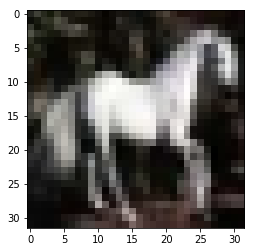

In [9]:
%matplotlib inline
from matplotlib.pyplot import imshow
imshow(x_test[13], interpolation='nearest')